Навчальна вибірка: 800 прикладів
Тестова вибірка: 200 прикладів

ПОЧАТОК НАВЧАННЯ

Навчання FeedForward (10 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Навчання FeedForward (20 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Навчання Cascade (20 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Навчання Cascade (2x10 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Навчання Elman (15 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Навчання Elman (3x5 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


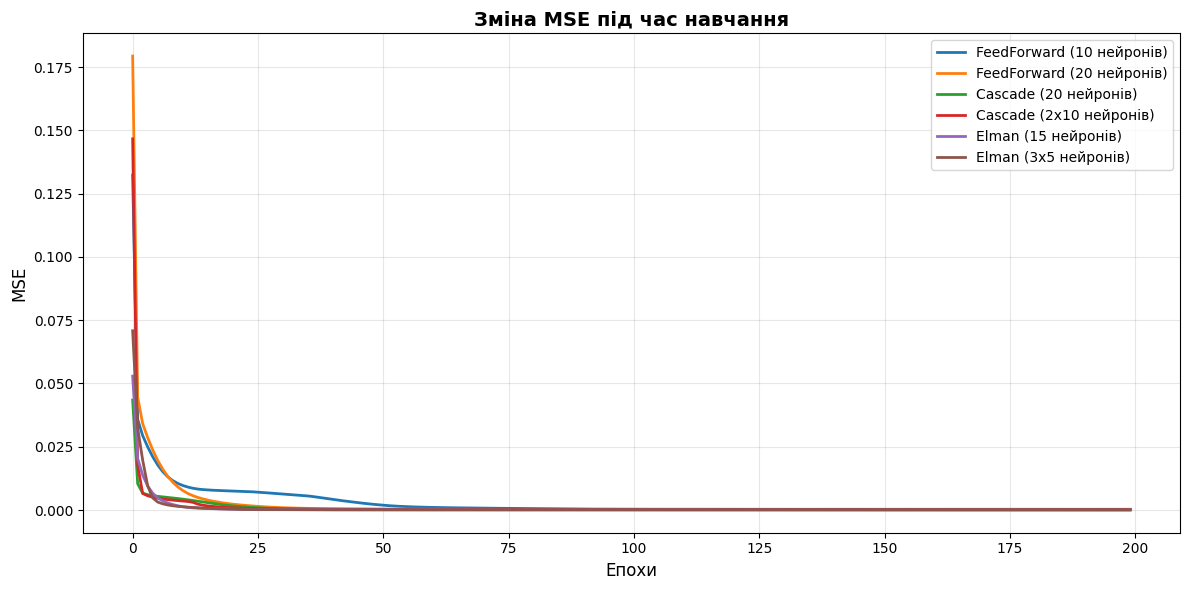


НАВЧАННЯ ЗАВЕРШЕНО



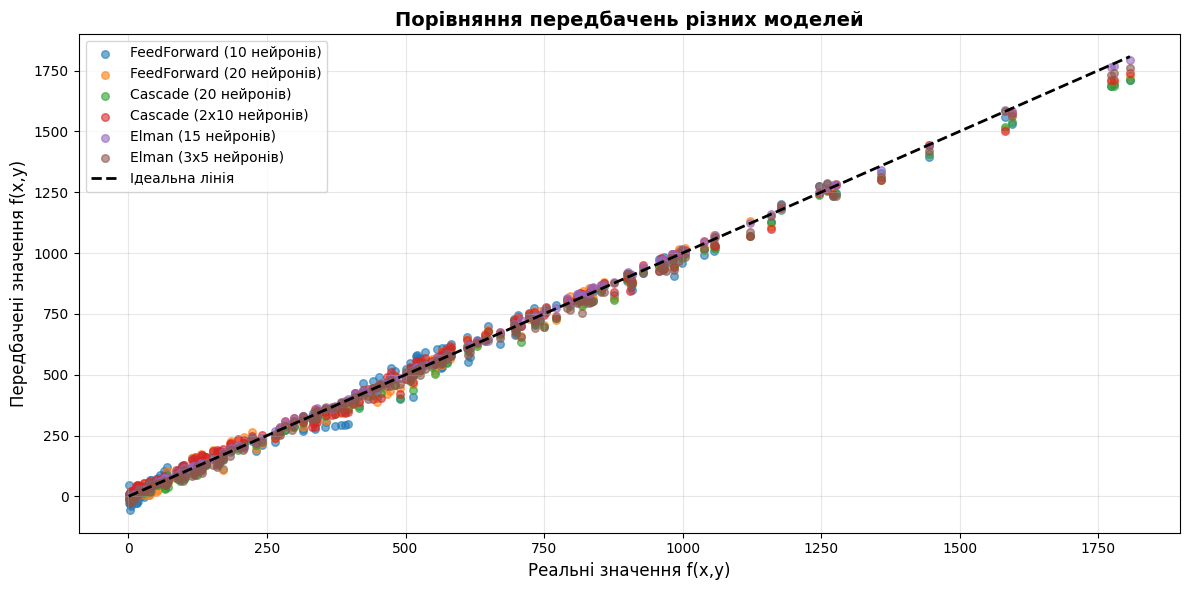


РЕЗУЛЬТАТИ МОДЕЛЮВАННЯ (оригінальний масштаб)
Модель                         Відносна помилка, %       R²                  
--------------------------------------------------------------------------------
FeedForward (10 нейронів)      17.5371                   0.9922              
FeedForward (20 нейронів)      17.5073                   0.9960              
Cascade (20 нейронів)          17.1755                   0.9960              
Cascade (2x10 нейронів)        17.7456                   0.9959              
Elman (15 нейронів)            17.7467                   0.9995              
Elman (3x5 нейронів)           17.2530                   0.9974              

ВИСНОВКИ
1. Найкраща модель: Cascade (20 нейронів)
   - Відносна помилка: 17.1755%
   - R²: 0.9960

2. Найгірша модель: Elman (15 нейронів)
   - Відносна помилка: 17.7467%
   - R²: 0.9995


In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Model, Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Add
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

def generate_data(n_samples=1000):
    X = np.random.uniform(0, 10, (n_samples, 2)).astype(np.float32)
    Y = (X[:, 0]**3 + X[:, 1]**3).astype(np.float32)
    return X, Y

scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X, Y = generate_data()
Y = Y.reshape(-1, 1)

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

X_train, X_test = X_scaled[:800], X_scaled[800:]
Y_train, Y_test = Y_scaled[:800], Y_scaled[800:]


def train_and_evaluate(model, X_train, Y_train, X_test, Y_test,
                       epochs=200, batch_size=10):
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(X_test, Y_test)
    )

    Y_pred = model.predict(X_test)

    Y_test_orig = scaler_Y.inverse_transform(Y_test)
    Y_pred_orig = scaler_Y.inverse_transform(Y_pred)

    error = np.mean(np.abs((Y_test_orig - Y_pred_orig.flatten()) / Y_test_orig))
    r2 = r2_score(Y_test_orig, Y_pred_orig)
    return history, error, Y_pred_orig, r2, Y_test_orig

print(f"Навчальна вибірка: {X_train.shape[0]} прикладів")
print(f"Тестова вибірка: {X_test.shape[0]} прикладів\n")

# Моделі

inputs = Input(shape=(2,))
hidden1 = Dense(20, activation="relu")(inputs)
output = Dense(1)(hidden1)
output_cascade = Dense(1)(inputs)
final_output = Add()([output, output_cascade])
cascade_model_1 = Model(inputs=inputs, outputs=final_output)

inputs_2 = Input(shape=(2,))
hidden1_2 = Dense(10, activation="relu")(inputs_2)
hidden2_2 = Dense(10, activation="relu")(hidden1_2)
output_2 = Dense(1)(hidden2_2)
output_cascade_2 = Dense(1)(inputs_2)
final_output_2 = Add()([output_2, output_cascade_2])
cascade_model_2 = Model(inputs=inputs_2, outputs=final_output_2)

models = {
    "FeedForward (10 нейронів)": Sequential([
        Input(shape=(2,)),
        Dense(10, activation="relu"),
        Dense(1)
    ]),
    "FeedForward (20 нейронів)": Sequential([
        Input(shape=(2,)),
        Dense(20, activation="relu"),
        Dense(1)
    ]),
    "Cascade (20 нейронів)": cascade_model_1,
    "Cascade (2x10 нейронів)": cascade_model_2,
    "Elman (15 нейронів)": Sequential([
        Input(shape=(2, 1)),
        SimpleRNN(15, activation="relu"),
        Dense(1)
    ]),
    "Elman (3x5 нейронів)": Sequential([
        Input(shape=(2, 1)),
        SimpleRNN(5, activation="relu", return_sequences=True),
        SimpleRNN(5, activation="relu", return_sequences=True),
        SimpleRNN(5, activation="relu"),
        Dense(1)
    ]),
}

errors = {}
predictions = {}
r2_scores = {}
y_test_orig_global = None

print("=" * 60)
print("ПОЧАТОК НАВЧАННЯ")
print("=" * 60 + "\n")

plt.figure(figsize=(12, 6))

for name, model in models.items():
    print(f"Навчання {name}...")
    if "Elman" in name:
        X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        history, error, y_pred, r2, y_true = train_and_evaluate(
            model, X_train_rnn, Y_train, X_test_rnn, Y_test
        )
    else:
        history, error, y_pred, r2, y_true = train_and_evaluate(
            model, X_train, Y_train, X_test, Y_test
        )

    errors[name] = error
    predictions[name] = y_pred
    r2_scores[name] = r2
    y_test_orig_global = y_true
    plt.plot(history.history["loss"], label=name, linewidth=2)

plt.title("Зміна MSE під час навчання", fontsize=14, fontweight="bold")
plt.xlabel("Епохи", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("НАВЧАННЯ ЗАВЕРШЕНО")
print("=" * 60 + "\n")

plt.figure(figsize=(12, 6))
for name, y_pred in predictions.items():
    plt.scatter(y_test_orig_global, y_pred, label=name, alpha=0.6, s=30)

plt.plot(
    [y_test_orig_global.min(), y_test_orig_global.max()],
    [y_test_orig_global.min(), y_test_orig_global.max()],
    "k--",
    linewidth=2,
    label="Ідеальна лінія",
)
plt.xlabel("Реальні значення f(x,y)", fontsize=12)
plt.ylabel("Передбачені значення f(x,y)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.title("Порівняння передбачень різних моделей", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТИ МОДЕЛЮВАННЯ (оригінальний масштаб)")
print("=" * 80)
print(f"{'Модель':<30} {'Відносна помилка, %':<25} {'R²':<20}")
print("-" * 80)

for name in models.keys():
    print(f"{name:<30} {errors[name]:<25.4f} {r2_scores[name]:<20.4f}")

print("=" * 80)

best_model = min(errors, key=errors.get)
worst_model = max(errors, key=errors.get)

print("\n" + "=" * 80)
print("ВИСНОВКИ")
print("=" * 80)
print(f"1. Найкраща модель: {best_model}")
print(f"   - Відносна помилка: {errors[best_model]:.4f}%")
print(f"   - R²: {r2_scores[best_model]:.4f}")
print(f"\n2. Найгірша модель: {worst_model}")
print(f"   - Відносна помилка: {errors[worst_model]:.4f}%")
print(f"   - R²: {r2_scores[worst_model]:.4f}")
print("=" * 80)
